In [322]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from sklearn.metrics import mean_squared_error

# BKK

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[0]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 120, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 1))

In [ ]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [ ]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

(7836, 4)

In [ ]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


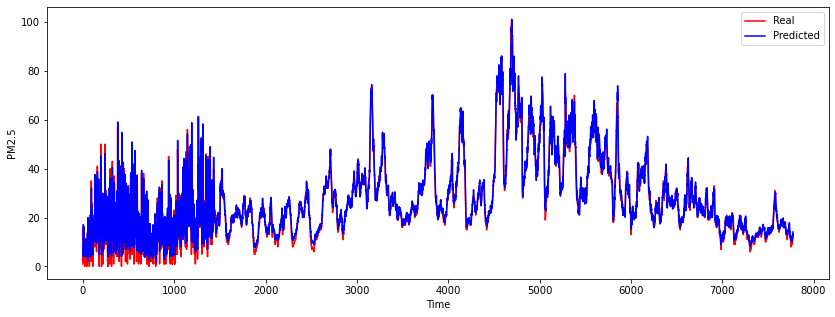

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Chiangmai

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[1]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 1))

In [ ]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [ ]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

(7836, 4)

In [ ]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


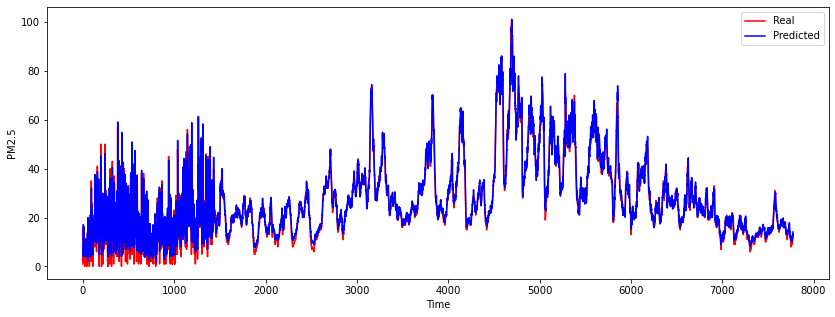

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Khonkaen

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[2]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 1))

In [ ]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [ ]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

(7836, 4)

In [ ]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


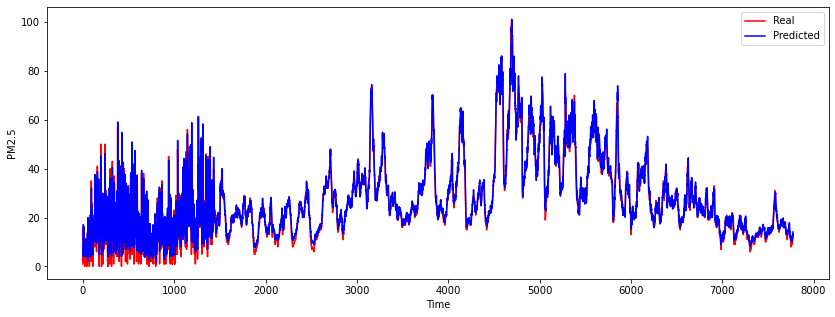

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Rayong

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[3]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 120, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 1))

In [ ]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [ ]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

(7836, 4)

In [ ]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


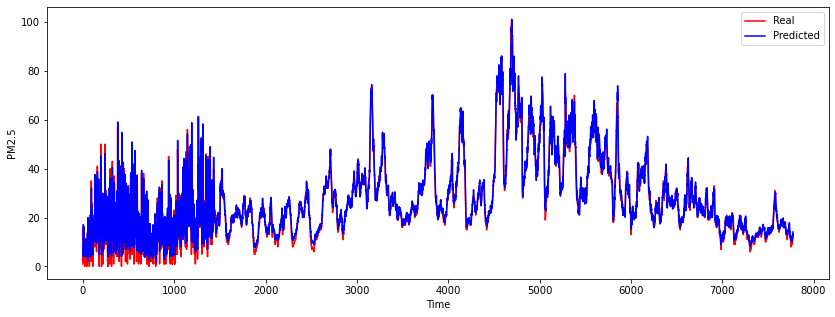

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Saraburi

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[4]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units = 1))

In [ ]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [ ]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

(7836, 4)

In [ ]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


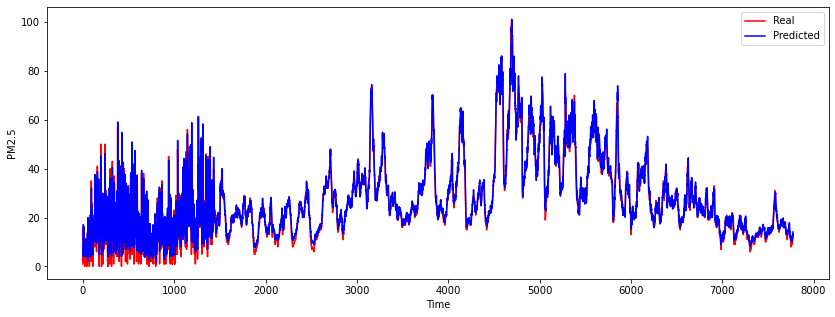

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Surat

In [323]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[5]
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [325]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.0,38.0,250.0
1,16.0,25.0,38.0,250.0
2,13.0,25.0,38.0,250.0
3,18.0,25.0,38.0,250.0
4,29.0,25.0,38.0,250.0


In [326]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
123,123,2020-07-06 03:00:00,NaN,25.3,17,260,14.685833,100.871996
5836,5836,2021-03-01 04:00:00,NaN,23.5,26,175,14.685833,100.871996
7344,7344,2021-05-03 00:00:00,27.0,27.7,5,290,14.685833,100.871996
655,655,2020-07-28 07:00:00,7.0,26.6,10,185,14.685833,100.871996
5422,5422,2021-02-11 22:00:00,NaN,25.4,3,70,14.685833,100.871996


In [327]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,2.0,25.9,41,250
1,2020-07-01 01:00:00,NaN,25.5,41,255
2,2020-07-01 02:00:00,NaN,25.5,41,255
3,2020-07-01 03:00:00,3.0,25.5,41,255
4,2020-07-01 04:00:00,5.0,25.1,49,265


In [328]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [330]:
# temp = (data_training * scale) + scaler.min_
# temp

array([[ 20.99753695,  10.4795539 ,  38.        , 250.        ],
       [ 14.99753695,  10.4795539 ,  38.        , 250.        ],
       [ 11.99753695,  10.4795539 ,  38.        , 250.        ],
       ...,
       [ 14.99753695,  12.8795539 ,  31.        , 245.        ],
       [  9.99753695,  11.3795539 ,  41.        , 250.        ],
       [  5.99753695,  11.3795539 ,  41.        , 250.        ]])

In [332]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [336]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 240, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))



modelLSTM.add(Dense(units = 1))

In [337]:
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 120)               60000     
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 60,121
Trainable params: 60,121
Non-trainable params: 0
_________________________________________________________________


In [339]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [340]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [341]:
history = modelLSTM.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 56s 67ms/step - loss: 9.2078e-04 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 58s 71ms/step - loss: 4.4753e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 58s 71ms/step - loss: 3.4225e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 59s 71ms/step - loss: 3.0990e-04 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 59s 72ms/step - loss: 3.0089e-04 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 58s 71ms/step - loss: 2.8285e-04 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 58s 70ms/step - loss: 2.9304e-04 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 62s 76ms/step - loss: 2.8004e-04 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 63s 77ms/step - loss: 2.7486e-04 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 64s 79ms/step - loss: 2.6738e-04 - lr: 0.0010

In [342]:
data_training = pd.read_csv(province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [344]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

,PM2.5,temp,wind speed,wind dir
0,2.0,25.9,41,250
1,NaN,25.5,41,255
2,NaN,25.5,41,255
3,3.0,25.5,41,255
4,5.0,25.1,49,265


In [345]:
past_60_days = data_training.tail(90)

In [346]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,18.0,30.5,9.0,235.0
1,18.0,33.1,12.0,245.0
2,14.0,33.1,12.0,245.0
3,8.0,33.1,12.0,245.0
4,6.0,33.4,17.0,245.0


In [347]:
df.dropna(inplace=True)
df.shape

In [348]:
df.shape

(7836, 4)

In [349]:
inputs = scaler.transform(df)
inputs

array([[0.04187192, 0.6133829 , 0.0989011 , 0.65277778],
       [0.04187192, 0.71003717, 0.13186813, 0.68055556],
       [0.0320197 , 0.71003717, 0.13186813, 0.68055556],
       ...,
       [0.02955665, 0.58364312, 0.26373626, 0.65277778],
       [0.0320197 , 0.58364312, 0.27472527, 0.66666667],
       [0.0320197 , 0.58364312, 0.26373626, 0.69444444]])

In [350]:
X_test = []
y_test = []

for i in range(90, inputs.shape[0]):
    X_test.append(inputs[i-90:i])
    y_test.append(inputs[i, 0])

In [351]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7776, 60, 4), (7776,))

In [352]:
y_pred = modelLSTM.predict(X_test)

In [355]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

406.0

In [356]:
y_pred = y_pred*scale
y_test = y_test*scale

In [357]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Saraburi RMSE = 3.1962012873265464


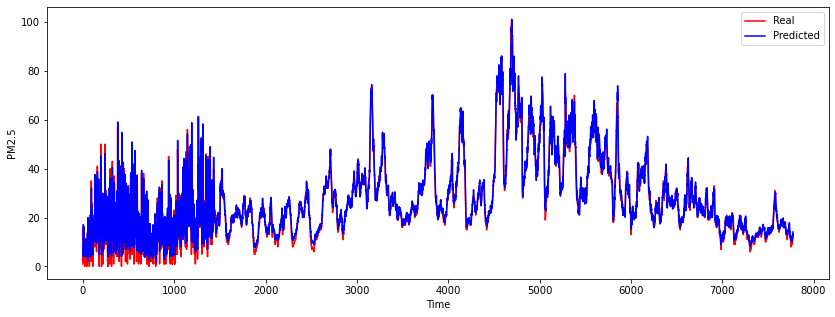

In [358]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [359]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [360]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Submit

In [ ]:
param_dict = {'BKK':[7.0, 70.0, 40.0, 100.0],
'Chiangmai':[7.0, 50.0, 40.0, 100.0],
'Rayong':[2.0, 50.0, 30.0, 40.0],
'Saraburi':[3.0, 50.0, 20.0, 90.0],
'Khonkaen':[1.0, 70.0, 30.0, 90.0],
'Surat':[2.0, 60.0, 20.0, 30.0]}

In [ ]:
ans = pd.DataFrame.from_dict({'Time':[],'Predicted':[],'PM2.5':[],'Province':[]})
for key,value in param_dict.items():
    
    df1 = pd.read_csv(key+'_clean.csv')
    df1.dropna(inplace=True)
    df1.reset_index(inplace=True)
    
    df2 = pd.read_csv('lstm_'+key.lower()+'.csv')
   

    df3 =  pd.DataFrame()
    df3['Predicted']=df1['date_time'].copy()
    df3['PM2.5']=df2['0'].copy()


    df3['Predicted'] = pd.to_datetime(df3['Predicted'])

    submit=pd.read_csv('submit_time_format_2.csv')
    submit['Predicted'] = pd.to_datetime(submit['Predicted'])
    submit['Time'] = pd.to_datetime(submit['Time'])

   
    result = pd.merge(submit, df3, how="left", on=["Predicted"])

    result['Province'] = key

    
    ans = pd.concat([ans,result])

In [ ]:
ans.dropna(inplace=True)
ans.reset_index(inplace=True)
ans['PM2.5'].to_csv('kaggle_lstm.csv')